# FPP multi objective optimization

### Import packages

In [1]:
#@time using WarmupFUSE
@time using FUSE
using Plots; gr();
FUSE.logging(Logging.Info; actors=Logging.Error);

 70.883989 seconds (114.19 M allocations: 7.302 GiB, 5.83% gc time, 32.10% compilation time: 39% of which was recompilation)


### Setup distributed computing environment

See more details here: https://fuse.help/parallel.html

In [2]:
FUSE.parallel_environment("saga", 120)
using Distributed
#@time @everywhere import WarmupFUSE
@time @everywhere import FUSE

connecting to worker 1 out of 119
connecting to worker 2 out of 119
connecting to worker 3 out of 119
connecting to worker 4 out of 119
connecting to worker 5 out of 119
connecting to worker 6 out of 119
connecting to worker 7 out of 119
connecting to worker 8 out of 119
connecting to worker 9 out of 119
connecting to worker 10 out of 119
connecting to worker 11 out of 119
connecting to worker 12 out of 119
connecting to worker 13 out of 119
connecting to worker 14 out of 119
connecting to worker 15 out of 119
connecting to worker 16 out of 119
connecting to worker 17 out of 119
connecting to worker 18 out of 119
connecting to worker 19 out of 119
connecting to worker 20 out of 119
connecting to worker 21 out of 119
connecting to worker 22 out of 119
connecting to worker 23 out of 119
connecting to worker 24 out of 119
connecting to worker 25 out of 119
connecting to worker 26 out of 119
connecting to worker 27 out of 119
connecting to worker 28 out of 119
connecting to worker 29 out o

### Get `ini` and `act` for FPP case and custmize as needed

In [3]:
ini, act = FUSE.case_parameters(:FPP; version=:v1_demount, init_from=:scalars, STEP=true)
act.ActorPFcoilsOpt.optimization_scheme = :none; # don't spend time optimizing the PFs

### As a good practice, test the actor/workflow that you want to optimize first

In [4]:
@time dd = FUSE.init(ini, act)
@time FUSE.ActorWholeFacility(dd, act);

294.338457 seconds (599.33 M allocations: 30.252 GiB, 5.76% gc time, 94.83% compilation time)
131.917706 seconds (617.94 M allocations: 19.167 GiB, 4.85% gc time, 61.56% compilation time: 9% of which was recompilation)


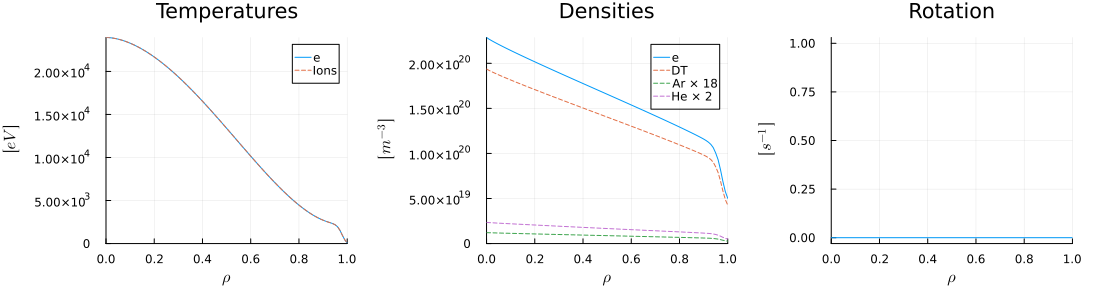

In [5]:
#IMAS.freeze(dd.balance_of_plant)
plot(dd.core_profiles)

### Define optimization variables and ranges

In [6]:
# nominal value and ranges
ini_opt = deepcopy(ini)
ini_opt.ec_launchers.power_launched = ini.ec_launchers.power_launched[1] ↔ [1e6, 200e6];
ini_opt.core_profiles.zeff = ini.core_profiles.zeff ↔ [1.1, 2.5]
#ini_opt.equilibrium.δ = ini.equilibrium.δ ↔ [-0.7,0.7]
#ini_opt.equilibrium.ζ = ini.equilibrium.ζ ↔ [0,0.2]
ini_opt.equilibrium.κ = missing # k set to be 95% of maximum controllable value
ini_opt.equilibrium.B0 = ini.equilibrium.B0 ↔ [1.0, 20.]
ini_opt.equilibrium.ip = ini.equilibrium.ip ↔ [1.0e6, 22e6]
ini_opt.equilibrium.R0 = ini.equilibrium.R0 ↔ [ini.equilibrium.R0, 10.0];

### See what are the possible optimization objectives and constraints

In [7]:
# FUSE comes with a library of objective and constraints functions
OFL = deepcopy(FUSE.ObjectiveFunctionsLibrary)
CFL = deepcopy(FUSE.ConstraintFunctionsLibrary)
println("== OBJECTIVE FUNCTIONS ==")
display(OFL)
println()
println("== CONSTRAINT FUNCTIONS ==")
display(CFL)

== OBJECTIVE FUNCTIONS ==


:max_power_electric_net => max_power_electric_net → Inf [MW]
:min_levelized_CoE => min_levelized_CoE → -Inf [$/kWh]
:max_fusion => max_fusion → Inf [MW]
:max_log10_flattop => max_log10_flattop → Inf [log₁₀(hours)]
:min_capital_cost => min_capital_cost → -Inf [$B]
:max_flattop => max_flattop → Inf [hours]
:min_βn => min_βn → -Inf []
:min_log10_levelized_CoE => min_log10_levelized_CoE → -Inf [log₁₀($/kW)]



== CONSTRAINT FUNCTIONS ==


:target_power_electric_net => target_power_electric_net == NaN ± NaN [MW]
:target_Beta_n => target_Beta_n == NaN ± NaN []
:zero_ohmic => zero_ohmic == 0.0 ± 0.01 [MA]
:steady_state => steady_state > 1.0 [log₁₀(hours)]


## Set the optimization objectives and constraints

In [8]:
objective_functions = [OFL[:min_βn], OFL[:min_capital_cost]]

# setup the constraint functions
CFL[:target_power_electric_net].limit = 200.0
CFL[:target_power_electric_net].tolerance = 0.01
constraint_functions = [CFL[:target_power_electric_net], CFL[:zero_ohmic]]

# ...but one can define custom objective/constraint functions too
# my_target_power_electric_net = FUSE.ObjectiveFunction(:my_target_power_electric_net, "MW", dd -> @ddtime(dd.balance_of_plant.power_electric_net)/1E6, 200.0)
# objective_functions = [my_target_power_electric_net, OFL[:min_βn], OFL[:min_capital_cost]]

display(objective_functions)
display(constraint_functions)

2-element Vector{FUSE.ObjectiveFunction}:
 min_βn → -Inf []
 min_capital_cost → -Inf [$B]

2-element Vector{FUSE.ConstraintFunction}:
 target_power_electric_net == 200.0 ± 2.0 [MW]
 zero_ohmic == 0.0 ± 0.01 [MA]

### Setup and run optimization

In [ ]:
# option to resume an optimization where it was left off
if false
    continue_results = results
else
    continue_results = missing
end

# define optimization parameters
# For real optimization studies the population size (N) and number of iterations should be bigger
# eg. N=100, iterations=25
optimization_parameters = Dict(
    :N => max(4, Int(floor((nprocs()-1)/2))*2), # even number
    :iterations => 100,
    :continue_results => continue_results,
    :save_folder => "/mnt/beegfs/users/meneghini/optimization_run_STEP_nodelta_zerohm_expressions_jfix")

# run optimization
results = FUSE.workflow_multiobjective_optimization(ini_opt, act, FUSE.ActorWholeFacility, objective_functions, constraint_functions; optimization_parameters...);

Running on 119 worker processes
== Actuators ==
ini.equilibrium.B0
- units: T
- description: Vacuum toroidal field at R0 [T]; Positive sign means anti-clockwise when viewing from above. The product R0B0 must be consistent with the b_tor_vacuum_r field of the tf IDS.
- value: 4.713171689711136
- base: 4.713171689711136
- default: missing
- lower: 1.0
- upper: 20.0
ini.equilibrium.R0
- units: m
- description: Geometric genter of the plasma. NOTE: This also scales the radial build layers.
- value: 4.824432302041749
- base: 4.824432302041749
- default: missing
- lower: 4.824432302041749
- upper: 10.0
ini.equilibrium.ip
- units: A
- description: Plasma current (toroidal component). Positive sign means anti-clockwise when viewed from above.
- value: 8.0e6
- base: 8.0e6
- default: missing
- lower: 1.0e6
- upper: 2.2e7
ini.core_profiles.zeff
- units: -
- description: Effective ion charge
- value: 2.0
- base: 2.0
- default: missing
- lower: 1.1
- upper: 2.5
ini.ec_launchers.power_launched
- uni

Iteration   2%|▌                           |  ETA: 13:13:33 ( 8.10  m/it)

## Release distributed resources

In [ ]:
for i in workers()
    rmprocs(i)
end

### Save optimization results to file

In [ ]:
# Optimization results can be re-loaded this way:
filename = "optimization_runs/optimization.bson"
@time results = FUSE.load_optimization(filename);

### How to: Define and use a custom FUSE workflow

In [ ]:
# Here `@everywhere` is needed to make all processes aware of the custom function
@everywhere function workflow_custom(ini, act)
    FUSE.init(dd, ini, act)
    FUSE.ActorEquilibriumTransport(dd, act)
    FUSE.ActorCXbuild(dd, act)
    return dd
end

# results = FUSE.workflow_multiobjective_optimization(ini, act, custom_workflow, objective_functions; optimization_parameters...);